In [13]:
%run Text_Preprocessing.ipynb

Documentation:
1. Converted class label to categorical
2. Supplied (original) vectorisers + TF-IDF vectorizer
3. Added preprocessing (punctuation removal, casefolding, stop-words removal (including words to short), lemmatization) steps to the text features
4. Encoded the simple string features ('Authors', 'Publisher', 'Language')
5. Dimensionality reduction with TruncatedSVD
6. Bigrams instead of words
7. Feature selection with SelectKBest
8. Standardization of 'pageNumbers' 
9. Instead of 8: Take the log of the standardized 'pageNumbers' using MinMaxScaler

Yet to try:
* Discretisation of PageNumbers

In [113]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy
from scipy import sparse
import re

In [114]:
import warnings
warnings.filterwarnings('ignore')

In [115]:
# Load datasets
original_train_df = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
original_test_df = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
print("Training set size:", len(original_train_df))
print("Test set size:", len(original_test_df))

Training set size: 23063
Test set size: 5766


In [244]:
# Make a copy of the original datasets
train_df = original_train_df.copy()
test_df = original_test_df.copy()

## Preprocess String features: Language, Authors, and Publisher

In [245]:
from sklearn.preprocessing import OneHotEncoder

In [246]:
STRING_FEATURES = ['Authors', 'Publisher', 'Language']

In [247]:
for feature in STRING_FEATURES:
    print(f"There are {original_train_df[feature].nunique()} unique '{feature}' values.")
    print(f"There are {original_train_df[feature].isna().sum()} missing '{feature}' values.")

# Too many missing values in 'Language'. Let's drop it.

There are 16301 unique 'Authors' values.
There are 0 missing 'Authors' values.
There are 4247 unique 'Publisher' values.
There are 148 missing 'Publisher' values.
There are 18 unique 'Language' values.
There are 17202 missing 'Language' values.


In [248]:
def preprocess_string_feature(df, feature, ohe=None):
    # first preprocess the strings
    df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    
    if ohe is None:
        ohe = OneHotEncoder(handle_unknown='ignore')
        ohe.fit(df[[feature]])
    
    transformed_col = ohe.transform(df[[feature]])  # a sparse matrix
    transformed_df = pd.concat([df, pd.DataFrame.sparse.from_spmatrix(transformed_col).set_axis(ohe.categories_, axis=1, inplace=False)], axis=1)
    
    return transformed_df, ohe

In [249]:
train_df, ohe_author = preprocess_string_feature(train_df, 'Authors')
train_df, ohe_publisher = preprocess_string_feature(train_df, 'Publisher')
train_df = train_df.drop(STRING_FEATURES, axis=1)  # drop the original features
train_df

,Name,PublishYear,PublishMonth,PublishDay,pagesNumber,Description,rating_label,"(,)","(aaron bank,)","(aaron beck,)",...,"(zero three,)","(zoland books,)","(zonderkidz,)","(zondervan,)","(zondervan academic,)","(zondervan publishing company,)","(zone books,)","(zsolnay,)","(zubaan books penguin india,)","(zzdap publishing,)"
0,Best of Dr Jean: Reading & Writing,2005,6,1,48,Teachers will turn to this treasury of ideas a...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Here All Dwell Free,1991,10,1,364,Every human being lives a fairy tale -- an unc...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Boomer's Big Surprise,2005,3,31,32,<i>Boomer's Big Surprise</i> will have special...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"I'll Go and Do More: Annie Dodge Wauneka, Nava...",2004,9,1,293,<i>I'll Go and Do More</i> is the story of Ann...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Us,2005,7,7,352,"Since their days at Oxford, they've gone their...",3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,Black Coffee Blues,1997,8,1,120,"""If I lose the light of the sun, I will write ...",4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23059,America's Champion Swimmer: Gertrude Ederle,2005,6,1,32,"Trudy Ederle loved to swim, and she was determ...",4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23060,Crime and Custom in Savage Society,1989,2,15,132,Bronislaw Malinowski achieved international re...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23061,The Name and Nature of Poetry and Other Select...,1998,4,21,136,Lovers of Housman's poetry and admirers of his...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
# Preprocess the test set too
test_df, _ = preprocess_string_feature(test_df, 'Authors', ohe=ohe_author)
test_df, _ = preprocess_string_feature(test_df, 'Publisher', ohe=ohe_publisher)
test_df = test_df.drop(STRING_FEATURES, axis=1)  # drop the original features
test_df

,Name,PublishYear,PublishMonth,PublishDay,pagesNumber,Description,"(,)","(aaron bank,)","(aaron beck,)","(aaron hamburger,)",...,"(zero three,)","(zoland books,)","(zonderkidz,)","(zondervan,)","(zondervan academic,)","(zondervan publishing company,)","(zone books,)","(zsolnay,)","(zubaan books penguin india,)","(zzdap publishing,)"
0,Near Occasions of Grace,1993,1,1,118,Distilling the insights of more than 20 years ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Perfect Spot,1997,3,17,32,A surprising turn on a wilderness walk leads t...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Study Guide for Campbell Reece Biology,2005,1,1,544,This printed learning aid provides a concept m...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"To Rescue A Rogue (Company of Rogues, #12)",2006,9,5,432,Lady Mara St. Bride has never backed down from...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Soul Picnic: The Music and Passion of Laura Nyro,2002,5,3,352,<i>Soul Picnic: The Music and Passion of Laura...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,"The Wicca Herbal: Recipes, Magick, and Abundance",2003,9,1,274,This work details and demystifies 100 magical ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5762,Shifter's Desire: Vampire Fangs & Venom,2004,9,10,224,Shifters' Desire - Vampire Fangs and Venom By ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5763,El Metodo Silva de Control Mental,1999,12,14,224,El método Silva de Control Mental es un sistem...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5764,Renaissance and Renascences in Western Art,1972,6,21,242,<i>Renaissance and Renascences in Western Art<...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocess Numerical features: PublishDates and pagesNumber

### Data Visualisation

In [251]:
NUMERICAL_FEATURES = ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']

In [252]:
# Look at NMI of the numerical attributes
from sklearn.metrics.cluster import normalized_mutual_info_score

for feature in NUMERICAL_FEATURES:
    print(f"NMI for {feature} =", normalized_mutual_info_score(train_df[feature], train_df['rating_label']))

NMI for PublishYear = 0.005010413368619569
NMI for PublishMonth = 0.0007191125502055215
NMI for PublishDay = 0.0013529681241697595
NMI for pagesNumber = 0.01964529722439041


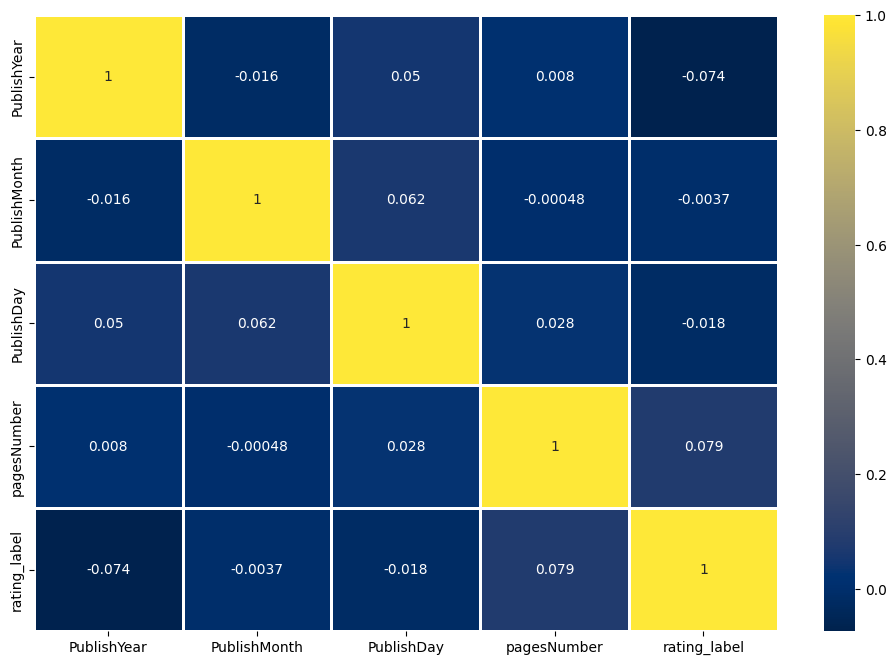

In [75]:
# Look at the correlation matrix of the numerical attributes
cor_matrix = train_df[NUMERICAL_FEATURES + ['rating_label']].corr()
round(cor_matrix, 2)
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='cividis', annot=True, linewidths=2)
plt.show()

# Looks like there's little correlation between the Publish time and rating_label

In [82]:
def plot_vs_rating(df, feature):
    plt.scatter(df[feature], df['rating_label'])
    plt.xlabel(feature)
    plt.ylabel('rating')

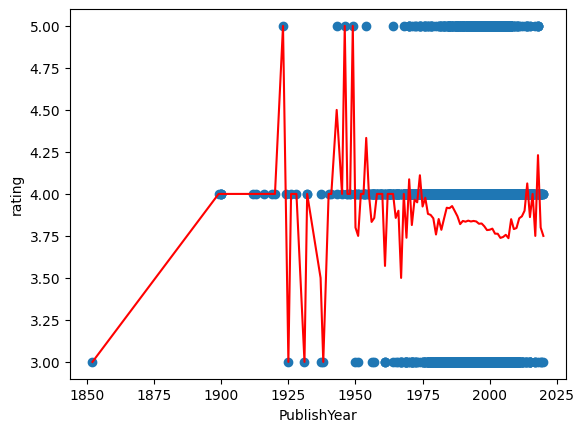

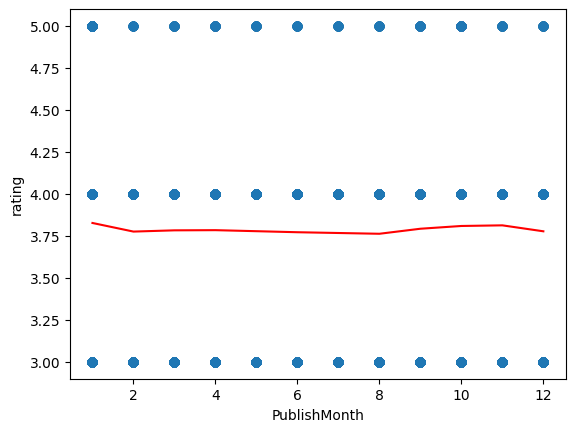

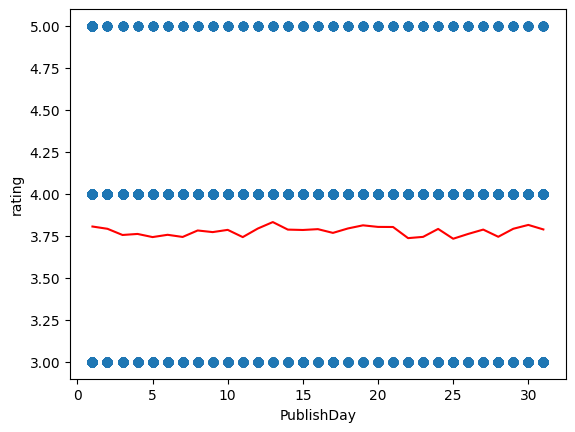

In [83]:
# Scatterplots for Publish year, month, and day vs. Rating
for feature in ['PublishYear', 'PublishMonth', 'PublishDay']: 
    plot_vs_rating(train_df, feature)
    
    # Look at the average rating for each value
    values, counts = np.unique(sorted(train_df[feature]), return_counts=True)
    avg = [sum(train_df.loc[train_df[feature] == values[i]]['rating_label']) / counts[i] for i in range(len(values))]
    plt.plot(values, avg, color = 'red')
    plt.show()

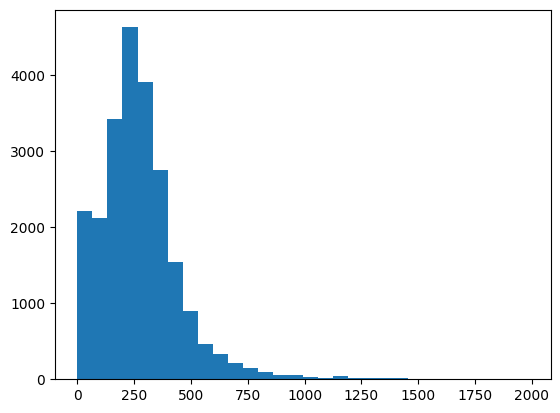

In [112]:
# Histogram for pages number < 2000
pageNum = train_df.loc[train_df['pagesNumber'] < 2000]['pagesNumber']
plt.hist(pageNum, bins = 30)
plt.show()

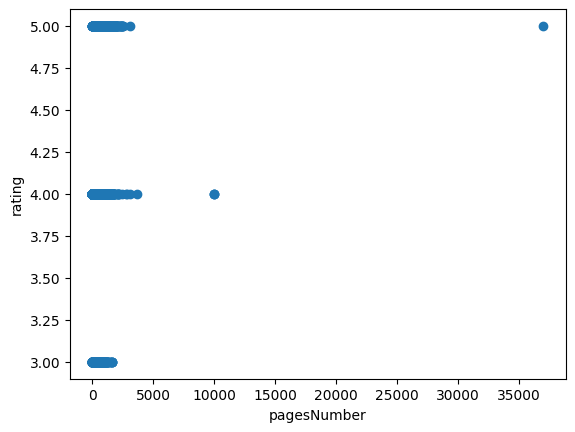

In [84]:
plot_vs_rating(train_df, 'pagesNumber')
plt.show()

In [217]:
# Try discretizing it
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=10):
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [218]:
DISCRETIZATION_STRATEGIES = ['kmeans', 'quantile', 'uniform']

def tune_discretization(X, y, feature, lower, upper):
    """
    Returns the combination of n (number of bins) and discretisation strategy 
    that gives the highest normalised mutual information between `X` and `y`.
    """
    
    max_nmi = 0
    best_n = 0
    best_strategy = None
    
    for n in range(lower, upper+1):
        for strategy in DISCRETIZATION_STRATEGIES:
            transformed_X, _ = discretize(X, feature, strategy=strategy, n_bins=n)
            nmi = normalized_mutual_info_score(transformed_X[feature], y)
            if nmi > max_nmi:
                max_nmi = nmi
                best_n = n
                best_strategy = strategy
    
    return max_nmi, best_n, best_strategy

In [253]:
max_nmi, best_n, best_strategy = tune_discretization(X_full_train, y_full_train, 'pagesNumber', 2, 20)
print("The number of bins that gives the highest NMI with rating_label is", best_n)
print("The highest NMI is:", max_nmi)
print("The best strategy is:", best_strategy)

The number of bins that gives the highest NMI with rating_label is 0.013006785743756806
The highest NMI is: 7
The best strategy is: kmeans


In [254]:
train_df, discretizer_pn = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)
np.unique(train_df['pagesNumber'], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([ 7578, 10024,  4422,   917,   118,     3,     1]))

In [255]:
train_df['pagesNumber'].corr(y_full_train)

0.09178865540456746

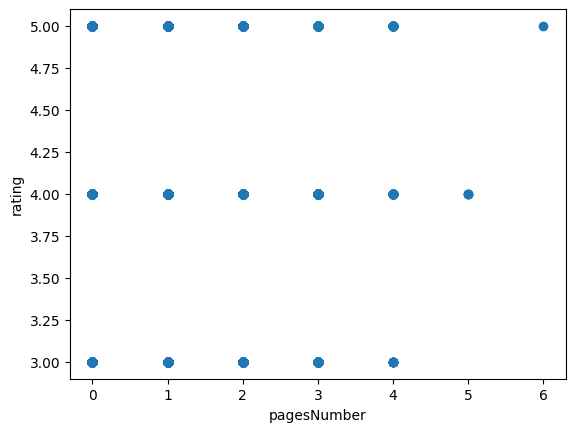

In [222]:
plot_vs_rating(train_df, 'pagesNumber')

In [256]:
# Try discretizing PublishYear as well 
max_nmi, best_n, best_strategy = tune_discretization(X_full_train, y_full_train, 'PublishYear', 2, 100)
print("The number of bins that gives the highest NMI with rating_label is", best_n)
print("The highest NMI is:", max_nmi)
print("The best strategy is:", best_strategy)

The number of bins that gives the highest NMI with rating_label is 0.006425277331391137
The highest NMI is: 15
The best strategy is: uniform


In [257]:
train_df, discretizer_py = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)
np.unique(train_df['PublishYear'], return_counts=True)

(array([ 0.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 array([    1,     5,     4,     6,     8,    19,    59,   233,  1080,
         5058, 16219,   371]))

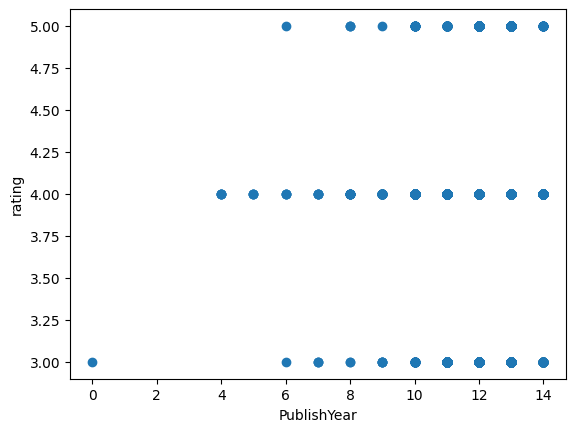

In [212]:
plot_vs_rating(train_df, 'PublishYear')

## Text Pre-processing

In [258]:
%run Text_Preprocessing.ipynb

In [259]:
train_name, vocab_name = preprocess_with_tfidf_vectorizer('Name', train_df, ngram=2)  # can try ngram=1
train_desc, vocab_desc = preprocess_with_tfidf_vectorizer('Description', train_df, ngram=2)

In [236]:
vocab_name.vocabulary_

{'reading writing': 205,
 'gay lesbian': 91,
 'secret life': 224,
 'travel guide': 265,
 'seventeenth century': 231,
 'best practice': 25,
 'next generation': 185,
 'delicious recipe': 62,
 'american indian': 7,
 'twentieth century': 272,
 'collected story': 52,
 'race class': 204,
 'united state': 275,
 'hank cowdog': 101,
 'natural history': 175,
 'new york': 184,
 'survival guide': 260,
 'crash course': 60,
 'around world': 14,
 'common sense': 54,
 'world war': 297,
 'american woman': 10,
 'rock roll': 215,
 'van gogh': 278,
 'civil war': 50,
 'essential guide': 73,
 'self defense': 229,
 'old testament': 190,
 'complete guide': 56,
 'louis amour': 152,
 'field guide': 82,
 'african american': 1,
 'old new': 189,
 'new england': 179,
 'art war': 17,
 'selected poem': 227,
 'native american': 173,
 'spiritual life': 246,
 'san francisco': 218,
 'nathaniel hawthorne': 171,
 'fairy tale': 79,
 'volume one': 281,
 'horrible harry': 116,
 'williams sonoma': 292,
 'inside story': 122,
 '

In [237]:
train_df_name = pd.DataFrame(train_name.todense())
train_df_name = train_df_name.set_axis(vocab_name.vocabulary_, axis=1, inplace=False)  # rename the columns with the vocabs
train_df_name

,reading writing,gay lesbian,secret life,travel guide,seventeenth century,best practice,next generation,delicious recipe,american indian,twentieth century,...,small town,fifty year,mountain man,great american,best american,vogue knitting,illustrated guide,every day,spanish english,made easy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [238]:
vocab_desc.vocabulary_

{'fairy tale': 91,
 'love story': 147,
 'life time': 137,
 'child book': 50,
 'one best': 189,
 'best known': 21,
 'health care': 118,
 'family friend': 93,
 'left behind': 132,
 'revised edition': 229,
 'book includes': 35,
 'fifty year': 98,
 'middle class': 159,
 'young man': 297,
 'book help': 34,
 'book written': 44,
 'human right': 127,
 'english language': 79,
 'one world': 200,
 'gay lesbian': 112,
 'point view': 210,
 'help student': 120,
 'new york': 181,
 'york city': 292,
 'two year': 271,
 'year old': 291,
 'common sense': 60,
 'popular culture': 211,
 'one hundred': 193,
 'hundred year': 128,
 'year ago': 289,
 'american history': 9,
 'short story': 237,
 'need know': 167,
 'daily life': 67,
 'life death': 134,
 'high school': 122,
 'anyone interested': 12,
 'also included': 5,
 'york time': 293,
 'time bestselling': 259,
 'bestselling author': 23,
 'new life': 176,
 'essential reading': 81,
 'new light': 177,
 'natural world': 166,
 'four year': 110,
 'ever since': 83,
 

In [240]:
train_df_desc = pd.DataFrame(train_desc.todense())
train_df_desc = train_df_desc.set_axis(vocab_desc.vocabulary_, axis=1, inplace=False)
train_df_desc

,fairy tale,love story,life time,child book,one best,best known,health care,family friend,left behind,revised edition,...,love affair,north america,paperback edition,book cover,book one,family life,civil right,step instruction,young girl,everything need
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
# Bind them together
train_df = pd.concat([train_df, train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(['Name', 'Description'], axis=1)  # drop the original columns
train_df

KeyError: "['Name', 'Description'] not found in axis"

In [261]:
train_df = train_df.drop(['Name', 'Description'], axis=1)
train_df

,PublishYear,PublishMonth,PublishDay,pagesNumber,rating_label,"(,)","(aaron bank,)","(aaron beck,)","(aaron hamburger,)","(aaron hass,)",...,love affair,north america,paperback edition,book cover,book one,family life,civil right,step instruction,young girl,everything need
0,13.0,6,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.0,10,1,2.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,3,31,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.0,9,1,1.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,7,7,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,12.0,8,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23059,13.0,6,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23060,12.0,2,15,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23061,13.0,4,21,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Convert rating_label to categorical class label

In [ ]:
# Finally, convert rating_label to categorical class label
def preprocess_class_label(df):
    df['rating_label'] = df['rating_label'].astype('category')
    return df

In [ ]:
train_df = preprocess_class_label(df)

In [ ]:
# Check class distributions
class_labels, count = np.unique(train_df['rating_label'], return_counts=True)
for pair in zip(class_labels, count):
    print(f"Rating {pair[0]}: {pair[1]} instances")

train_df: original training set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes\
test_df: original test set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes\
x_full_train: attributes in train_df\
y_train: class labels (rankings) in train_df\
x_full_test: attributes in test_df\
text_matrix: sparse matrix consisting of the 'Description' and 'Name' feature vectors\
numerical_matrix: matrix containing the (encoded) 'Authors', 'Publisher', 'Language' features\
X_train: fully transformed matrix combining text_matrix and numerical_matrix, representing the training set\
X_test: fully transformed matrix combining text_matrix and numerical_matrix, representing the training set


Dimensionality reduction: Truncated singular value decomposition (SVD)\
Unlike PCA, this estimator does not center the data before computing the SVD. This means it can work with sparse matrices efficiently.

In [ ]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_selection import SelectKBest

In [ ]:
def transform_to_df(name_matrix, desc_matrix, numerical_matrix):
    df_name = 

In [155]:
# Split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, train_size=0.8, random_state=30027)

In [ ]:
# Feature selection
selector = SelectKBest(k=20)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
print(X_train.shape)
print(X_val.shape)

In [ ]:
# Check NMI of each column with the rating label
for i in range(X_train.shape[1]):
    print(f"NMI for component {i} =", normalized_mutual_info_score(X_train.toarray()[:,i], y_train))

In [ ]:
import seaborn
df = pd.DataFrame.sparse.from_spmatrix(X_train)
df = df.sparse.to_dense()
y_df = y_train.reset_index()
del y_df['index']

df = pd.concat([df, pd.DataFrame(y_df.values)], ignore_index = True, axis = 1)
seaborn.pairplot(df)

# Model Induction on Training set

In [ ]:
# scoring for cross validation
def report_scoring(clf, X, y, include_avg=True): 
    y_pred = clf.predict(X)
    results = classification_report(y, y_pred, output_dict=True, zero_division=0)
    
    report_dict = {}  # set up our own output dictionary
    for label in ['3.0', '4.0', '5.0']: 
        for metric in ['precision', 'recall', 'f1-score']: 
            report_dict[label + '_' + metric] = results[label][metric]
    report_dict['accuracy'] = results['accuracy']
    
    if include_avg:
        for metric in ['precision', 'recall', 'f1-score']:
            report_dict['macro_avg_' + metric] = results['macro avg'][metric]
            report_dict['weighted_avg_' + metric] = results['weighted avg'][metric]
    
    return report_dict

In [ ]:
def get_model_name(model):
    """
    Returns the name of the sklearn classifier.
    """
    return re.findall(r'(\w+)\(', str(model))[0]

In [ ]:
import time

In [ ]:
def validate(clf, X, y, print_full_results=True):
    """
    Evaluates the classifier on the given dataset.
    """
    start = time.time()
    # cross validation on TRAINING set
    result = cross_validate(clf, X, y, scoring=report_scoring, cv=20)
    end = time.time()
    print(f"{get_model_name(clf)} prediction took {end - start} seconds")
    
    # Convert evaluation results to a dataframe ("test_" prefix is auto-generated)
    results_df = pd.DataFrame.from_dict(result)[['test_3.0_f1-score','test_4.0_f1-score','test_5.0_f1-score','test_accuracy']]
    if print_full_results:
        print(results_df)
    
    return results_df.mean(axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def evaluate(clf, X, y, print_confusion_matrix=True, print_classification_report=True):
    y_pred = clf.predict(X)
    if print_confusion_matrix:
        cm = confusion_matrix(y, y_pred)
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        display.plot()
        plt.show()
    
    if print_classification_report:
        print(classification_report(y, y_pred, zero_division=0))
    
    return y_pred

In [ ]:
def validate_and_test(clf, X_train, y_train, X_val, y_val, print_full_cv_results=True, print_confusion_matrix=True, print_classification_report=True):
    clf.fit(X_train, y_train)
    print("Evaluate on training set:\n")
    print(validate(clf, X_train, y_train, print_full_results=print_full_cv_results))
    print("\n\nEvaluate on validation set:\n")
    return evaluate(clf, X_val, y_val, print_confusion_matrix=print_confusion_matrix, print_classification_report=print_classification_report)

## Error Analysis

In [ ]:
def get_correct_classifications(y_true, y_pred, class_label=None):
    """
    Returns a list of integers, representing the index of the correctly classified instances, 
    in the original training set (original_train_df).
    If class_label is specified, only considers the correct classification in that class.
    """
    
    y_true_copy = y_true.reset_index()  # now a dataframe with two columns, 'index' and 'rating_label'
    if class_label is None:
        match_idx = [i for i in range(len(y_pred)) if y_true_copy.iloc[i,:]['rating_label'] == y_pred[i]]
    
    else: # have a specific class label for interest
        y_true_filtered = y_true_copy[y_true_copy['rating_label'] == class_label]['rating_label']
        y_pred_filtered = pd.Series(y_pred)[y_pred == class_label]
        match_idx = y_true_filtered.index.intersection(y_pred_filtered.index).tolist()  # correct predictions
    
    original_idx = y_true_copy.iloc[match_idx,:]['index']  # index in the original training set
    return original_idx

## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# scoring for hyperparameter tuning
def hyperparameter_scoring(clf, X, y): 
    y_pred = clf.predict(X)
    results = classification_report(y, y_pred, output_dict=True, zero_division=0)
    
    report_dict = {}  # set up our own output dictionary
    for label in ['3.0', '4.0', '5.0']: 
        for metric in ['f1-score']: 
            report_dict[label + '_' + metric] = results[label][metric]
    report_dict['accuracy'] = results['accuracy']
    #for metric in ['precision', 'recall', 'f1-score']:
        #report_dict['weighted_avg_' + metric] = results['weighted avg'][metric]
    
    return report_dict

In [ ]:
def tune_hyperparameter(clf, param_grid, X_train, y_train): 
    grid_search = GridSearchCV(clf, param_grid, scoring=hyperparameter_scoring, cv=20, verbose=2, refit=False)
    grid_search.fit(X_train, y_train)
    result_df = pd.DataFrame.from_dict(grid_search.cv_results_)
    r = re.compile('^((mean|rank)_test|params).*')
    score_metrics = list(filter(r.match, result_df.columns))
    return result_df[score_metrics]


## Naive Bayes

In [131]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

Evaluate on training set:

GaussianNB prediction took 0.2621293067932129 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.410078           0.000000           0.086957       0.257855
1            0.408304           0.003086           0.047619       0.257855
2            0.409367           0.000000           0.088889       0.257855
3            0.409367           0.003086           0.177778       0.261105
4            0.409367           0.003086           0.133333       0.260022
5            0.410435           0.000000           0.122449       0.258938
6            0.409722           0.003077           0.136364       0.260022
7            0.407986           0.000000           0.255319       0.261105
8            0.408696           0.012270           0.045455       0.260022
9            0.408304           0.000000           0.139535       0.258938
10           0.410792           0.000000           0.166667       0.260304
11           0.4069

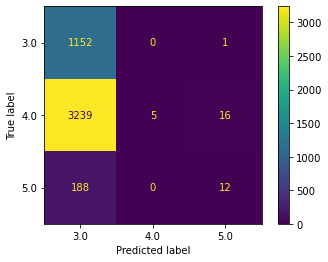

              precision    recall  f1-score   support

         3.0       0.25      1.00      0.40      1153
         4.0       1.00      0.00      0.00      3260
         5.0       0.41      0.06      0.10       200

    accuracy                           0.25      4613
   macro avg       0.56      0.35      0.17      4613
weighted avg       0.79      0.25      0.11      4613



In [120]:
gnb = GaussianNB()
y_pred = validate_and_test(gnb, X_train.toarray(), y_train, X_val.toarray(), y_val)

### Compare rating 5 instances

In [ ]:
original_train_df[original_train_df['rating_label'] == 5.0]

In [ ]:
original_train_df.iloc[get_correct_classifications(y_val, y_pred, class_label=5.0),:]

Evaluate on training set:

MultinomialNB prediction took 0.23177289962768555 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824505           0.093023       0.702059
1                 0.0           0.824204           0.000000       0.700975
2                 0.0           0.824729           0.048780       0.702059
3                 0.0           0.825559           0.177778       0.704225
4                 0.0           0.823229           0.046512       0.699892
5                 0.0           0.824505           0.093023       0.702059
6                 0.0           0.825782           0.139535       0.704225
7                 0.0           0.826837           0.222222       0.706392
8                 0.0           0.825255           0.047619       0.702059
9                 0.0           0.825255           0.095238       0.703142
10                0.0           0.826837           0.186047       0.706074
11             

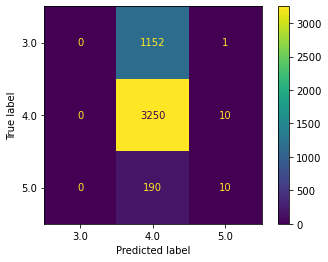

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.48      0.05      0.09       200

    accuracy                           0.71      4613
   macro avg       0.39      0.35      0.31      4613
weighted avg       0.52      0.71      0.59      4613



In [132]:
mnb = MultinomialNB()
y_pred = validate_and_test(mnb, X_train.toarray(), y_train, X_val.toarray(), y_val)

## SVM

### Linear

In [ ]:
from sklearn import svm

In [ ]:
linearSVM = svm.LinearSVC(random_state=30027, C=10) # set C?
linearSVM.fit(X_train, y_train)
validate_and_test(linearSVM, X_train, y_train, X_val, y_val)

Evaluate on training set:

SGDClassifier prediction took 0.5179867744445801 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824204                0.0       0.700975
1                 0.0           0.824204                0.0       0.700975
2                 0.0           0.824204                0.0       0.700975
3                 0.0           0.824204                0.0       0.700975
4                 0.0           0.824204                0.0       0.700975
5                 0.0           0.824204                0.0       0.700975
6                 0.0           0.824204                0.0       0.700975
7                 0.0           0.824204                0.0       0.700975
8                 0.0           0.824204                0.0       0.700975
9                 0.0           0.824204                0.0       0.700975
10                0.0           0.824729                0.0       0.701735
11              

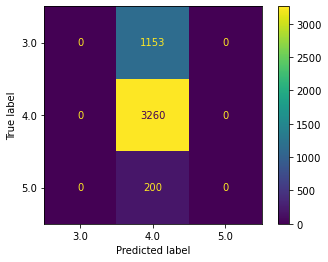

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [119]:
# Linear SVM using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' predicts most 4s as 3s
# validation accuracy stops increasing for eta0 < 0.0000001
svm_sgd = SGDClassifier(learning_rate='adaptive', eta0 = 0.0000001)  # default: loss='hinge' -> gives a linear SVM
validate_and_test(svm_sgd, X_train, y_train, X_val, y_val)

### Kernel SVM

In [ ]:
# tune hyperparameter C
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9)
param_grid = {'C': range(1, 10)}
grid_search_result = tune_hyperparameter(RBF_svm, param_grid, X_train, y_train)

In [ ]:
grid_search_result

Evaluate on training set:

SVC prediction took 120.91550493240356 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824505           0.093023       0.702059
1                 0.0           0.824729           0.048780       0.702059
2                 0.0           0.824729           0.048780       0.702059
3                 0.0           0.825559           0.177778       0.704225
4                 0.0           0.823229           0.046512       0.699892
5                 0.0           0.824505           0.093023       0.702059
6                 0.0           0.825782           0.139535       0.704225
7                 0.0           0.826837           0.222222       0.706392
8                 0.0           0.824204           0.000000       0.700975
9                 0.0           0.825255           0.095238       0.703142
10                0.0           0.825559           0.139535       0.703905
11                0.0     

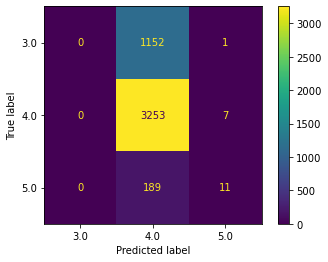

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.58      0.06      0.10       200

    accuracy                           0.71      4613
   macro avg       0.43      0.35      0.31      4613
weighted avg       0.53      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [118]:
# Try kernel SVM
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9, C=10)
validate_and_test(RBF_svm, X_train, y_train, X_val, y_val)

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# tune hyperparameters p and K
knn = KNeighborsClassifier(weights = 'distance')
param_grid = {'p': [1,2], 'n_neighbors': range(1,11)}
grid_search_result = tune_hyperparameter(knn, param_grid, X_train, y_train)

In [ ]:
grid_search_result
# p=2 (euclidean distance) is generally better
# larger k models prefers label 4.0 and hence results in higher accuracy due to data imbalance

Evaluate on training set:

KNeighborsClassifier prediction took 9.68991994857788 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.230047           0.741065           0.122449       0.606717
1            0.247086           0.745812           0.045455       0.613218
2            0.209366           0.779708           0.136364       0.652221
3            0.270784           0.750182           0.153846       0.624052
4            0.186667           0.764706           0.046512       0.630553
5            0.257426           0.763819           0.122449       0.635970
6            0.168865           0.754584           0.122449       0.617551
7            0.225420           0.748191           0.255319       0.617551
8            0.278960           0.759071           0.044444       0.631636
9            0.221154           0.751262           0.093023       0.616468
10           0.228117           0.779733           0.173913       0.651844
11         

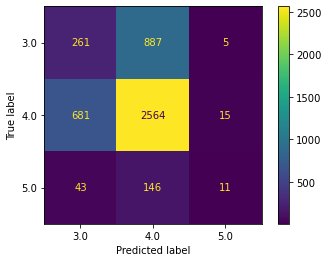

              precision    recall  f1-score   support

         3.0       0.26      0.23      0.24      1153
         4.0       0.71      0.79      0.75      3260
         5.0       0.35      0.06      0.10       200

    accuracy                           0.61      4613
   macro avg       0.44      0.36      0.36      4613
weighted avg       0.59      0.61      0.59      4613



array([3., 4., 3., ..., 4., 3., 3.])

In [117]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
validate_and_test(knn, X_train, y_train, X_val, y_val)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# tune hyperparameter max_depth
dtc = DecisionTreeClassifier(random_state = 30027)
param_grid = {'max_depth': range(2,21)}
grid_search_result = tune_hyperparameter(dtc, param_grid, X_train, y_train)

In [ ]:
grid_search_result
# smaller depth converge towards 0R and prefers 4.0 label

Evaluate on training set:

DecisionTreeClassifier prediction took 1.367140769958496 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.053030           0.812256           0.166667       0.686891
1            0.037594           0.808068           0.000000       0.678223
2            0.057554           0.806303           0.133333       0.677140
3            0.081181           0.812827           0.170213       0.689057
4            0.037175           0.805737           0.046512       0.676056
5            0.061776           0.817414           0.125000       0.693391
6            0.022222           0.805501           0.204082       0.674973
7            0.049645           0.800792           0.250000       0.671723
8            0.057762           0.805774           0.088889       0.676056
9            0.051282           0.805229           0.093023       0.677140
10           0.052434           0.814090           0.136364       0.687636
11      

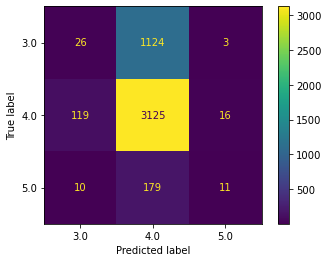

              precision    recall  f1-score   support

         3.0       0.17      0.02      0.04      1153
         4.0       0.71      0.96      0.81      3260
         5.0       0.37      0.06      0.10       200

    accuracy                           0.69      4613
   macro avg       0.41      0.35      0.32      4613
weighted avg       0.56      0.69      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [116]:
dtc = DecisionTreeClassifier(max_depth=20, random_state = 30027)
validate_and_test(dtc, X_train, y_train, X_val, y_val)

## Logistic Regression

In [138]:
# doc2vec
DESCRIPTION_TRAIN_SET = './preprocessed_data/doc2Vec/train_Description_2grams_doc2vec.csv'
NAME_TRAIN_SET = './preprocessed_data/doc2Vec/train_Name_2grams_doc2vec.csv'
NUMERICAL_TRAIN_SET = './preprocessed_data/train_numerical.npz'

DESCRIPTION_TEST_SET = './preprocessed_data/doc2Vec/test_Description_2grams_doc2vec.csv'
NAME_TEST_SET = './preprocessed_data/doc2Vec/test_Name_2grams_doc2vec.csv'
NUMERICAL_TEST_SET = './preprocessed_data/test_numerical.npz'
FILE_TYPE = 'csv'

In [139]:
X_full_train = transform_to_matrix(DESCRIPTION_TRAIN_SET, NAME_TRAIN_SET, NUMERICAL_TRAIN_SET, file_type=FILE_TYPE, dimensionality_reduction=False)
#X_test = transform_to_matrix(DESCRIPTION_TEST_SET, NAME_TEST_SET, NUMERICAL_TEST_SET, file_type=FILE_TYPE)
X_full_train.shape

(23063, 24530)

In [159]:
# Split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, train_size=0.8, random_state=30027)

Evaluate on training set:

LogisticRegression prediction took 225.6245560646057 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.267559           0.829561           0.133333       0.721560
1            0.284768           0.829787           0.000000       0.722644
2            0.307190           0.835901           0.297872       0.734561
3            0.314465           0.828051           0.133333       0.722644
4            0.288591           0.833777           0.090909       0.728061
5            0.288591           0.835662           0.222222       0.732394
6            0.380645           0.847957           0.139535       0.752979
7            0.293333           0.837675           0.367347       0.736728
8            0.317881           0.838667           0.181818       0.737811
9            0.328173           0.830520           0.095238       0.725894
10           0.351438           0.839490           0.142857       0.740781
11          

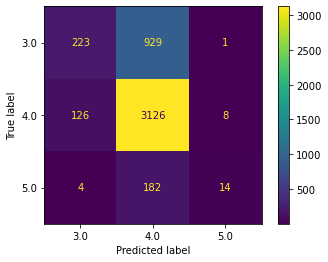

              precision    recall  f1-score   support

         3.0       0.63      0.19      0.30      1153
         4.0       0.74      0.96      0.83      3260
         5.0       0.61      0.07      0.13       200

    accuracy                           0.73      4613
   macro avg       0.66      0.41      0.42      4613
weighted avg       0.71      0.73      0.67      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [156]:
from sklearn.linear_model import LogisticRegression
# using full feature set
logr = LogisticRegression()
validate_and_test(logr, X_train, y_train, X_val, y_val)

In [166]:
# Feature selection
selector = SelectKBest(k=100)
selector.fit(X_train, y_train)
X_train_reduced = selector.transform(X_train)
X_val_reduced = selector.transform(X_val)
print(X_train_reduced.shape)
print(X_val_reduced.shape)

(18450, 100)
(4613, 100)


Evaluate on training set:

LogisticRegression prediction took 6.984812021255493 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.000000           0.825559           0.177778       0.704225
1            0.008439           0.825255           0.048780       0.703142
2            0.033333           0.828956           0.222222       0.710726
3            0.016807           0.826087           0.136364       0.705309
4            0.016807           0.824808           0.090909       0.703142
5            0.016736           0.825336           0.136364       0.704225
6            0.008439           0.825032           0.093023       0.703142
7            0.008439           0.828425           0.297872       0.709642
8            0.000000           0.825032           0.136364       0.703142
9            0.016807           0.826309           0.095238       0.705309
10           0.016807           0.826615           0.139535       0.706074
11          

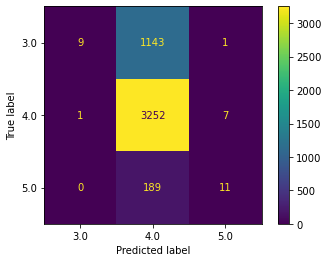

              precision    recall  f1-score   support

         3.0       0.90      0.01      0.02      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.58      0.06      0.10       200

    accuracy                           0.71      4613
   macro avg       0.73      0.35      0.32      4613
weighted avg       0.75      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [167]:
# using reduced feature set
validate_and_test(logr, X_train_reduced, y_train, X_val_reduced, y_val)



In [122]:
# Logistic regression using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' -> validation accuracy = 0.535
# probabilistic -> different accuracy each time
# eta0=0.0000001 -> low variance, capped at 0.698
# eta0=0.001 -> high variance, occasionally reached 0.7
logr_sgd = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.0000001)
validate_and_test(logr_sgd, X_train, y_train, X_val, y_val)

ValueError: The loss log_loss is not supported. 

## Boosting

Evaluate on training set:

AdaBoostClassifier prediction took 13.508945941925049 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.000000           0.822023           0.127660       0.698808
1            0.000000           0.823980           0.047619       0.700975
2            0.000000           0.825255           0.095238       0.703142
3            0.000000           0.824281           0.136364       0.702059
4            0.000000           0.823229           0.046512       0.699892
5            0.000000           0.822023           0.125000       0.698808
6            0.000000           0.823980           0.047619       0.700975
7            0.000000           0.827366           0.217391       0.706392
8            0.000000           0.820972           0.043478       0.696641
9            0.000000           0.824204           0.000000       0.700975
10           0.000000           0.824505           0.048780       0.701735
11         

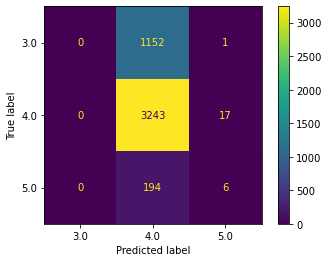

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      0.99      0.83      3260
         5.0       0.25      0.03      0.05       200

    accuracy                           0.70      4613
   macro avg       0.32      0.34      0.29      4613
weighted avg       0.51      0.70      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [123]:
from sklearn.ensemble import AdaBoostClassifier

adab = AdaBoostClassifier(n_estimators=100, random_state=30027)
validate_and_test(adab, X_train, y_train, X_val, y_val)

## Random Forest

Evaluate on training set:

RandomForestClassifier prediction took 7.203554153442383 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824204           0.000000       0.700975
1                 0.0           0.824204           0.000000       0.700975
2                 0.0           0.824204           0.000000       0.700975
3                 0.0           0.824729           0.048780       0.702059
4                 0.0           0.824204           0.000000       0.700975
5                 0.0           0.824204           0.000000       0.700975
6                 0.0           0.824729           0.048780       0.702059
7                 0.0           0.824729           0.048780       0.702059
8                 0.0           0.824204           0.000000       0.700975
9                 0.0           0.825255           0.095238       0.703142
10                0.0           0.825782           0.097561       0.703905
11      

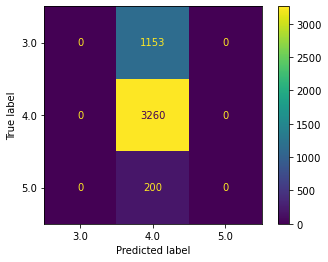

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [124]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=30027)
validate_and_test(rf, X_train, y_train, X_val, y_val)

## Stacking Classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
/Library/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale th

Evaluate on training set:



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
/Library/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale th

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
/Library/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
/Library/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
/Library/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

StackingClassifier prediction took 896.3090162277222 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824505           0.093023       0.702059
1                 0.0           0.823980           0.047619       0.700975
2                 0.0           0.824729           0.048780       0.702059
3                 0.0           0.826309           0.181818       0.705309
4                 0.0           0.823229           0.046512       0.699892
5                 0.0           0.823755           0.090909       0.700975
6                 0.0           0.825782           0.139535       0.704225
7                 0.0           0.827366           0.260870       0.707476
8                 0.0           0.825255           0.047619       0.702059
9                 0.0           0.825255           0.095238       0.703142
10                0.0           0.824808           0.136364       0.702820
11                0.0           0.82705

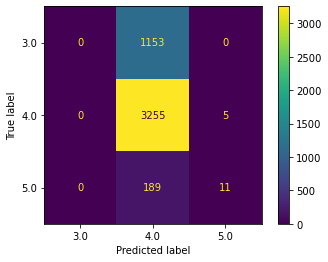

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.69      0.06      0.10       200

    accuracy                           0.71      4613
   macro avg       0.47      0.35      0.31      4613
weighted avg       0.53      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [126]:
from sklearn.ensemble import StackingClassifier

classifiers = [('linearSVM', linearSVM), ('svm_sgd', svm_sgd), ('RBF_svm', RBF_svm), ('knn', knn), ('dtc', dtc)]#, ('logr', logr)]
sc = StackingClassifier(classifiers, verbose = 1)
validate_and_test(sc, X_train, y_train, X_val, y_val)

In [ ]:
evaluate(stacking_clf, X_val, y_val, print_confusion_matrix=True, print_classification_report=True)

## Baseline - 0R & 1R

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.dummy import DummyClassifier

Evaluate on training set:

DummyClassifier prediction took 0.15984010696411133 seconds
test_3.0_f1-score    0.000000
test_4.0_f1-score    0.824766
test_5.0_f1-score    0.000000
test_accuracy        0.701789
dtype: float64


Evaluate on validation set:



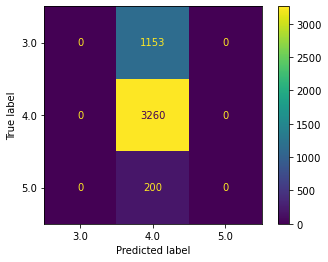

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613


*****************************

Evaluate on training set:

DecisionTreeClassifier prediction took 0.23511886596679688 seconds
test_3.0_f1-score    0.000000
test_4.0_f1-score    0.824766
test_5.0_f1-score    0.000000
test_accuracy        0.701789
dtype: float64


Evaluate on validation set:



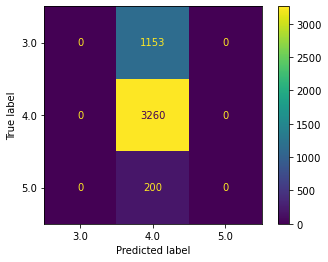

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613


*****************************



In [129]:
# build and test 0R and 1R model
zero_r = DummyClassifier(strategy='most_frequent')
one_r = DecisionTreeClassifier(max_depth=1)
baselines = [zero_r, one_r]

for baseline in baselines: 
    validate_and_test(baseline, X_train, y_train, X_val, y_val, print_full_cv_results=False)
    print("\n*****************************\n")